### 1. Load Libraries

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
import PIL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import RMSprop, Adam

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### 2. Load Data

The data consists of 3 folders - train, test, val. Train & test are used for modeling, validation will be used to check performance of model. Size of validation set (16 cases) is small.

In [2]:
path = '/Users/rajanrai/.keras/datasets/chest_xray'
data_dir = pathlib.Path(path)
train_dir = pathlib.Path(path + '/train')
val_dir = pathlib.Path(path + '/val')
test_dir = pathlib.Path(path + '/test')

In [3]:
data_dir

PosixPath('/Users/rajanrai/.keras/datasets/chest_xray')

In [4]:
image_count = len(list(data_dir.glob('*/*/*.jpeg')))
print(image_count)

5856


In [5]:
normal = list(data_dir.glob('train/NORMAL/*'))
pneumonia = list(data_dir.glob('train/PNEUMONIA/*'))

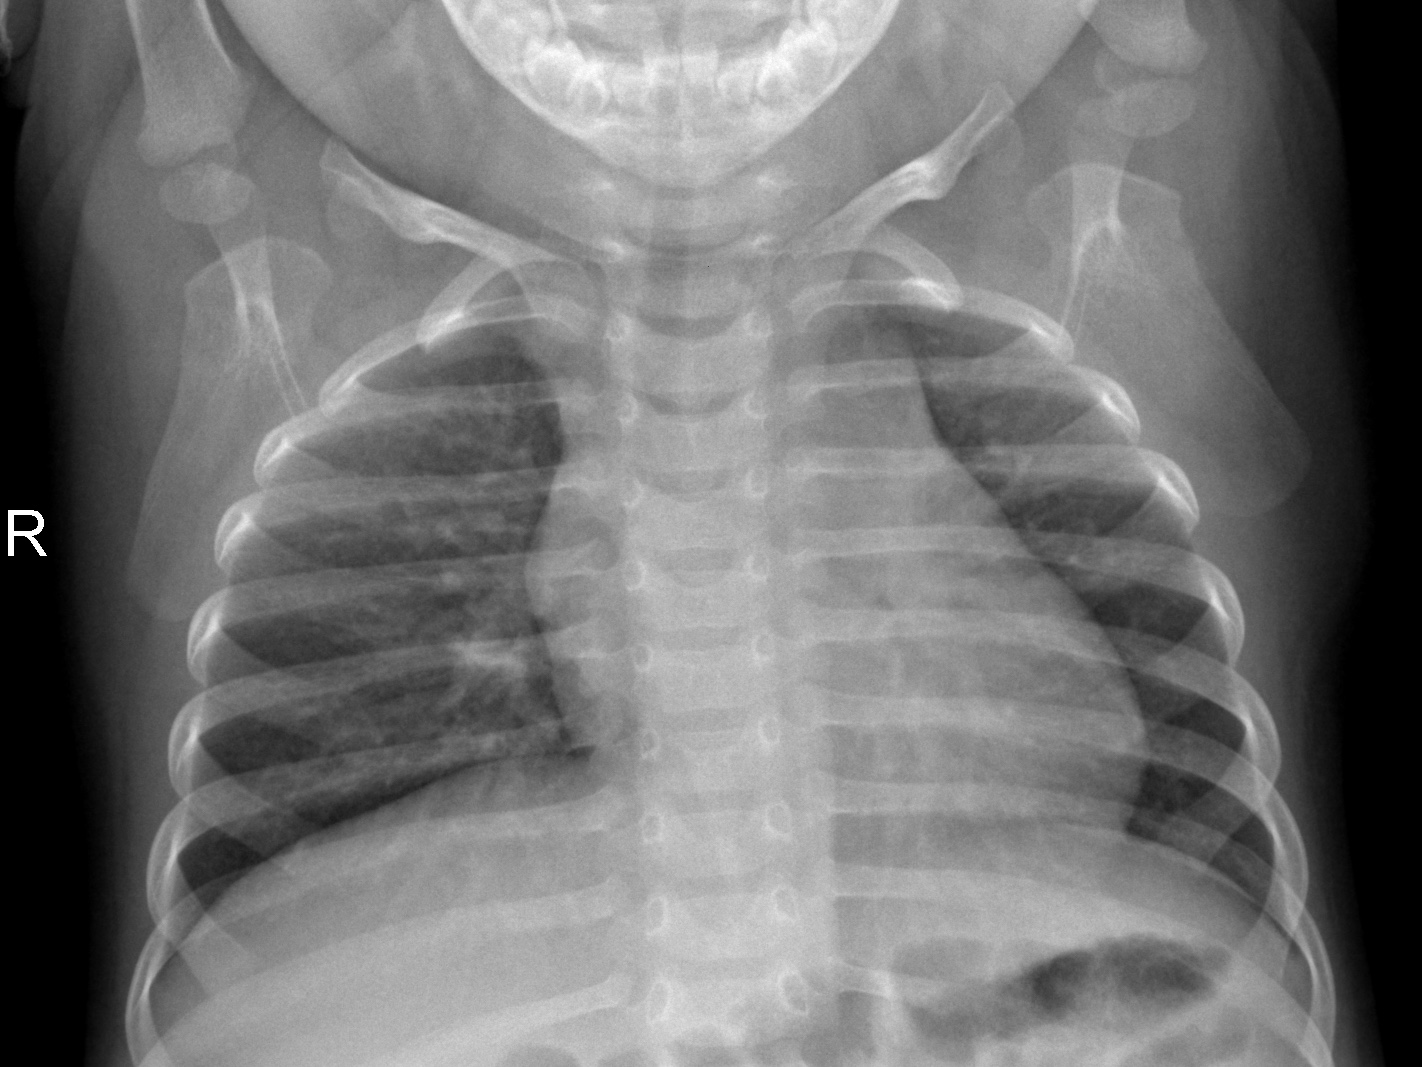

In [6]:
PIL.Image.open(str(normal[1]))

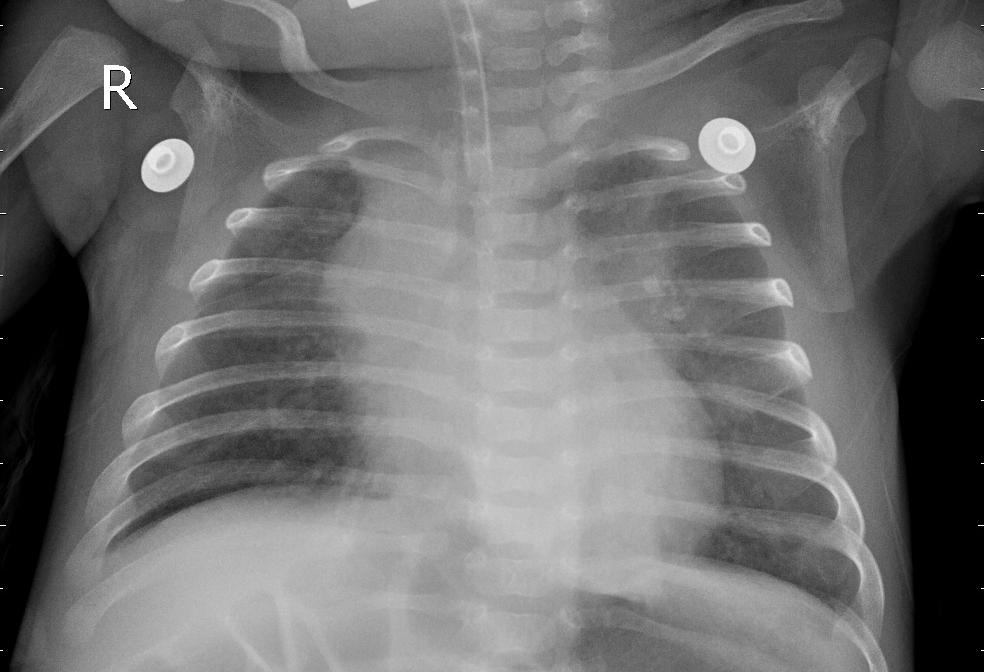

In [7]:
PIL.Image.open(str(pneumonia[1]))

### 3. Create Dataset

Define some parameters for the loader:

In [8]:
# Create dataset
batch_size = 32
img_height = 128
img_width = 128

#### Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
            seed=123,
            label_mode = 'binary',
            image_size =(img_height, img_width),
            batch_size = batch_size)

Found 5216 files belonging to 2 classes.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
            seed=123,
            label_mode = 'binary',
            image_size = (img_height, img_width),
            batch_size = batch_size)

Found 16 files belonging to 2 classes.


In [12]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
            seed=123,
            label_mode = 'binary',
            image_size =(img_height, img_width),
            batch_size = batch_size)

Found 624 files belonging to 2 classes.


In [14]:
# Pull out the class names using tensorflow built-in function
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

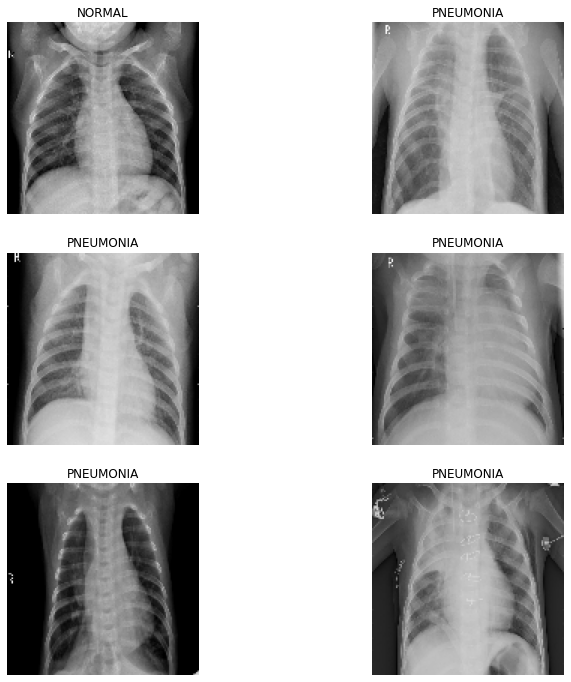

In [15]:
plt.figure(figsize=(12,12))
for images, labels in train_ds.take(1):
    labels = np.reshape(labels, (batch_size,)).astype("uint32")
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32, 1)


### 4. Configure the dataset for performance

__Dataset.cache()__ keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

__Dataset.prefetch()__ overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
epochs = 25

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 5. Create Model 

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 64 units on top of it that is activated by a relu activation function and followed by another fully connected layer that is activated by a sigmoid activation function.

In [18]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_height, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.1),
    ])

In [19]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [20]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Model Summary

View all the layers of the network using the model's summary method:

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)       

### 6. Train the model

In [22]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, steps_per_epoch=163)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
163/163 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.7332WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14d3c1200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

### 7. Visualize training results

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

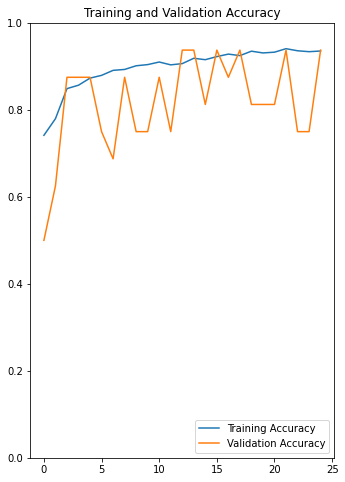

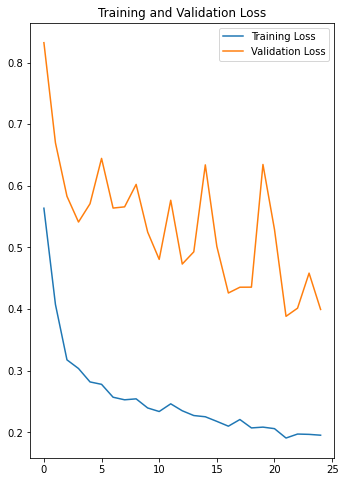

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.ylim([0, 1])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 8. Calculate Accuracy

In [29]:
test_accuracy = model.evaluate_generator(test_ds)

In [30]:
print('The accuracy on test set :',test_accuracy[1]*100)

The accuracy on test set : 91.50640964508057
